In [1]:
# Copyright 2015 The TensorFlow Authors. All Rights Reserved.
#
# Licensed under the Apache License, Version 2.0 (the "License");
# you may not use this file except in compliance with the License.
# You may obtain a copy of the License at
#
#     http://www.apache.org/licenses/LICENSE-2.0
#
# Unless required by applicable law or agreed to in writing, software
# distributed under the License is distributed on an "AS IS" BASIS,
# WITHOUT WARRANTIES OR CONDITIONS OF ANY KIND, either express or implied.
# See the License for the specific language governing permissions and
# limitations under the License.
# ==============================================================================

"""Simple, end-to-end, LeNet-5-like convolutional MNIST model example.

This should achieve a test error of 0.7%. Please keep this model as simple and
linear as possible, it is meant as a tutorial for simple convolutional models.
Run with --self_test on the command line to execute a short self-test.
"""
from __future__ import absolute_import
from __future__ import division
from __future__ import print_function

import argparse
import gzip
import os
import sys
import time

import numpy
from six.moves import urllib
from six.moves import xrange  # pylint: disable=redefined-builtin
import tensorflow as tf
import matplotlib.pyplot as plt
%matplotlib inline

SOURCE_URL = 'http://yann.lecun.com/exdb/mnist/'
WORK_DIRECTORY = 'data'
IMAGE_SIZE = 28
NUM_CHANNELS = 1
PIXEL_DEPTH = 255
NUM_LABELS = 10
VALIDATION_SIZE = 5000  # Size of the validation set.
SEED = 66478  # Set to None for random seed.
BATCH_SIZE = 64
NUM_EPOCHS = 10
EVAL_BATCH_SIZE = 64
EVAL_FREQUENCY = 100  # Number of steps between evaluations.


FLAGS = None

In [2]:
def data_type():
    return tf.float32

In [3]:
def maybe_download(filename):
    """Download the data from Yann's website, unless it's already here."""
    if not tf.gfile.Exists(WORK_DIRECTORY):
    tf.gfile.MakeDirs(WORK_DIRECTORY)
    filepath = os.path.join(WORK_DIRECTORY, filename)
    if not tf.gfile.Exists(filepath):
    filepath, _ = urllib.request.urlretrieve(SOURCE_URL + filename, filepath)
    with tf.gfile.GFile(filepath) as f:
        size = f.size()
    print('Successfully downloaded', filename, size, 'bytes.')
    return filepath

In [4]:
def extract_data(filename, num_images):
    """Extract the images into a 4D tensor [image index, y, x, channels].

    Values are rescaled from [0, 255] down to [-0.5, 0.5].
    """
    print('Extracting', filename)
    with gzip.open(filename) as bytestream:
        bytestream.read(16)
        buf = bytestream.read(IMAGE_SIZE * IMAGE_SIZE * num_images * NUM_CHANNELS)
        data = numpy.frombuffer(buf, dtype=numpy.uint8).astype(numpy.float32)
        data = (data - (PIXEL_DEPTH / 2.0)) / PIXEL_DEPTH
        data = data.reshape(num_images, IMAGE_SIZE, IMAGE_SIZE, NUM_CHANNELS)
    return data

In [5]:
def extract_labels(filename, num_images):
    """Extract the labels into a vector of int64 label IDs."""
    print('Extracting', filename)
    with gzip.open(filename) as bytestream:
        bytestream.read(8)
        buf = bytestream.read(1 * num_images)
        labels = numpy.frombuffer(buf, dtype=numpy.uint8).astype(numpy.int64)
    return labels

In [6]:
def error_rate(predictions, labels):
  """Return the error rate based on dense predictions and sparse labels."""
  return 100.0 - (
      100.0 *
      numpy.sum(numpy.argmax(predictions, 1) == labels) /
      predictions.shape[0])


In [7]:
# Get the data.
train_data_filename = maybe_download('train-images-idx3-ubyte.gz')
train_labels_filename = maybe_download('train-labels-idx1-ubyte.gz')
test_data_filename = maybe_download('t10k-images-idx3-ubyte.gz')
test_labels_filename = maybe_download('t10k-labels-idx1-ubyte.gz')

# Extract it into numpy arrays.
train_data = extract_data(train_data_filename, 60000)
train_labels = extract_labels(train_labels_filename, 60000)
test_data = extract_data(test_data_filename, 10000)
test_labels = extract_labels(test_labels_filename, 10000)

# Generate a validation set.
validation_data = train_data[:VALIDATION_SIZE, ...]
validation_labels = train_labels[:VALIDATION_SIZE]
train_data = train_data[VALIDATION_SIZE:, ...]
train_labels = train_labels[VALIDATION_SIZE:]
num_epochs = NUM_EPOCHS
train_size = train_labels.shape[0]


Extracting data\train-images-idx3-ubyte.gz
Extracting data\train-labels-idx1-ubyte.gz
Extracting data\t10k-images-idx3-ubyte.gz
Extracting data\t10k-labels-idx1-ubyte.gz


In [8]:
# This is where training samples and labels are fed to the graph.
# These placeholder nodes will be fed a batch of training data at each
# training step using the {feed_dict} argument to the Run() call below.
train_data_node = tf.placeholder(
  data_type(),
  shape=(BATCH_SIZE, IMAGE_SIZE, IMAGE_SIZE, NUM_CHANNELS))
train_labels_node = tf.placeholder(tf.int64, shape=(BATCH_SIZE,))
eval_data = tf.placeholder(
  data_type(),
  shape=(EVAL_BATCH_SIZE, IMAGE_SIZE, IMAGE_SIZE, NUM_CHANNELS))

# The variables below hold all the trainable weights. They are passed an
# initial value which will be assigned when we call:
# {tf.global_variables_initializer().run()}
conv1_weights = tf.Variable(
  tf.truncated_normal([5, 5, NUM_CHANNELS, 6],  # 5x5 filter, depth 6.
                      stddev=0.1,
                      seed=SEED, dtype=data_type()))
conv1_biases = tf.Variable(tf.zeros([6], dtype=data_type()))
conv3_weights = tf.Variable(tf.truncated_normal(
  [5, 5, 6, 16], stddev=0.1,
  seed=SEED, dtype=data_type()))
conv3_biases = tf.Variable(tf.constant(0.1, shape=[16], dtype=data_type()))
conv5_weights = tf.Variable(tf.truncated_normal(
  [IMAGE_SIZE // 4 * IMAGE_SIZE // 4*16, 120], stddev=0.1,
  seed=SEED, dtype=data_type()))
conv5_biases = tf.Variable(tf.constant(0.1, shape=[120], dtype=data_type()))
fc6_weights = tf.Variable(  # fully connected, depth 120.
  tf.truncated_normal([IMAGE_SIZE // 4 * IMAGE_SIZE // 4 * 16, 84],
                      stddev=0.1,
                      seed=SEED,
                      dtype=data_type()))
fc6_biases = tf.Variable(tf.constant(0.1, shape=[84], dtype=data_type()))
fc7_weights = tf.Variable(tf.truncated_normal([84, NUM_LABELS],
                                            stddev=0.1,
                                            seed=SEED,
                                            dtype=data_type()))
fc7_biases = tf.Variable(tf.constant(
  0.1, shape=[NUM_LABELS], dtype=data_type()))

## We will replicate the model structure for the training subgraph, as well as the evaluation subgraphs, while sharing the trainable parameters.

In [9]:

conv1 = []

class Model():
        
    def model(self, data, train=False):
        """The Model definition."""
        # 2D convolution, with 'SAME' padding (i.e. the output feature map has
        # the same size as the input). Note that {strides} is a 4D array whose
        # shape matches the data layout: [image index, y, x, depth].
        self.conv1 = tf.nn.conv2d(data,
                            conv1_weights,
                            strides=[1, 1, 1, 1],
                            padding='SAME')
        # Bias and rectified linear non-linearity.
        self.relu1 = tf.nn.relu(tf.nn.bias_add(self.conv1, conv1_biases))
        # Max pooling. The kernel size spec {ksize} also follows the layout of
        # the data. Here we have a pooling window of 2, and a stride of 2.
        self.pool2 = tf.nn.max_pool(self.relu1,
                              ksize=[1, 2, 2, 1],
                              strides=[1, 2, 2, 1],
                              padding='SAME')
        self.conv3 = tf.nn.conv2d(self.pool2,
                            conv3_weights,
                            strides=[1, 1, 1, 1],
                            padding='SAME')
        self.relu3 = tf.nn.relu(tf.nn.bias_add(self.conv3, conv3_biases))
        self.pool4 = tf.nn.max_pool(self.relu3,
                              ksize=[1, 2, 2, 1],
                              strides=[1, 2, 2, 1],
                              padding='SAME')
        # Reshape the feature map cuboid into a 2D matrix to feed it to the
        # fully connected layers.
        pool_shape = self.pool4.get_shape().as_list()
        reshape = tf.reshape(
            self.pool4,
            [pool_shape[0], pool_shape[1] * pool_shape[2] * pool_shape[3]])
        # Fully connected layer. Note that the '+' operation automatically
        # broadcasts the biases.
        self.hidden1 = tf.nn.relu(tf.matmul(reshape, conv5_weights) + conv5_biases)
        self.hidden2 = tf.nn.relu(tf.matmul(reshape, fc6_weights) + fc6_biases)
        # Add a 50% dropout during training only. Dropout also scales
        # activations such that no rescaling is needed at evaluation time.
        if train:
            self.hidden2 = tf.nn.dropout(self.hidden2, 0.5, seed=SEED)

        return tf.matmul(self.hidden2, fc7_weights) + fc7_biases


In [10]:
# Training computation: logits + cross-entropy loss.
model_train = Model()
logits = model_train.model(train_data_node, True)
loss = tf.reduce_mean(tf.nn.sparse_softmax_cross_entropy_with_logits(
      logits, train_labels_node))

# L2 regularization for the fully connected parameters.
regularizers = (tf.nn.l2_loss(conv5_weights) + tf.nn.l2_loss(conv5_biases) + tf.nn.l2_loss(fc6_weights) + tf.nn.l2_loss(fc6_biases) +
              tf.nn.l2_loss(fc7_weights) + tf.nn.l2_loss(fc7_biases))
# Add the regularization term to the loss.
loss += 5e-4 * regularizers

# Optimizer: set up a variable that's incremented once per batch and
# controls the learning rate decay.
batch = tf.Variable(0, dtype=data_type())
# Decay once per epoch, using an exponential schedule starting at 0.01.
learning_rate = tf.train.exponential_decay(
  0.01,                # Base learning rate.
  batch * BATCH_SIZE,  # Current index into the dataset.
  train_size,          # Decay step.
  0.95,                # Decay rate.
  staircase=True)
# Use simple momentum for the optimization.
optimizer = tf.train.MomentumOptimizer(learning_rate,
                                     0.9).minimize(loss,
                                                   global_step=batch)

# Predictions for the current training minibatch.
train_prediction = tf.nn.softmax(logits)

model_eval = Model()
# Predictions for the test and validation, which we'll compute less often.
eval_prediction = tf.nn.softmax(model_eval.model(eval_data))


In [11]:
# Small utility function to evaluate a dataset by feeding batches of data to
# {eval_data} and pulling the results from {eval_predictions}.
# Saves memory and enables this to run on smaller GPUs.
def eval_in_batches(data, sess):
    """Get all predictions for a dataset by running it in small batches."""
    size = data.shape[0]
    if size < EVAL_BATCH_SIZE:
        raise ValueError("batch size for evals larger than dataset: %d" % size)
    predictions = numpy.ndarray(shape=(size, NUM_LABELS), dtype=numpy.float32)
    for begin in xrange(0, size, EVAL_BATCH_SIZE):
        end = begin + EVAL_BATCH_SIZE
        if end <= size:
            predictions[begin:end, :] = sess.run(
                eval_prediction,
                feed_dict={eval_data: data[begin:end, ...]})
        else:
        batch_predictions = sess.run(
            eval_prediction,
            feed_dict={eval_data: data[-EVAL_BATCH_SIZE:, ...]})
        predictions[begin:, :] = batch_predictions[begin - size:, :]
    return predictions

# Create a local session to run the training.

In [12]:
import numpy as np
start_time = time.time()
sess = tf.Session()

# Run all the initializers to prepare the trainable parameters.
tf.global_variables_initializer().run(session=sess)
print('Initialized!')

# Loop through training steps.
for step in xrange(int(num_epochs * train_size) // BATCH_SIZE):
    # Compute the offset of the current minibatch in the data.
    # Note that we could use better randomization across epochs.
    offset = (step * BATCH_SIZE) % (train_size - BATCH_SIZE)
    batch_data = train_data[offset:(offset + BATCH_SIZE), ...]
    batch_labels = train_labels[offset:(offset + BATCH_SIZE)]
    # This dictionary maps the batch data (as a numpy array) to the
    # node in the graph it should be fed to.
    feed_dict = {train_data_node: batch_data,
               train_labels_node: batch_labels}
    # Run the optimizer to update weights.
    sess.run(optimizer, feed_dict=feed_dict)
    # print some extra information once reach the evaluation frequency
    if step % EVAL_FREQUENCY == 0:
        # fetch some extra nodes' data
        l, lr, predictions = sess.run([loss, learning_rate, train_prediction],
                                      feed_dict=feed_dict)
        elapsed_time = time.time() - start_time
        start_time = time.time()
        
        #getActivations(conv1,batch_data[0])
        print('Step %d (epoch %.2f), %.1f ms' %
              (step, float(step) * BATCH_SIZE / train_size,
               1000 * elapsed_time / EVAL_FREQUENCY))
        print('Minibatch loss: %.3f, learning rate: %.6f' % (l, lr))
        print('Minibatch error: %.1f%%' % error_rate(predictions, batch_labels))
        print('Validation error: %.1f%%' % error_rate(
            eval_in_batches(validation_data, sess), validation_labels))
        sys.stdout.flush()
# Finally print the result!
test_error = error_rate(eval_in_batches(test_data, sess), test_labels)
print('Test error: %.1f%%' % test_error)

Initialized!
Step 0 (epoch 0.00), 7.7 ms
Minibatch loss: 2.743, learning rate: 0.010000
Minibatch error: 90.6%
Validation error: 91.5%
Step 100 (epoch 0.12), 178.6 ms
Minibatch loss: 0.880, learning rate: 0.010000
Minibatch error: 23.4%
Validation error: 15.2%
Step 200 (epoch 0.23), 174.9 ms
Minibatch loss: 0.739, learning rate: 0.010000
Minibatch error: 14.1%
Validation error: 6.3%
Step 300 (epoch 0.35), 172.7 ms
Minibatch loss: 0.639, learning rate: 0.010000
Minibatch error: 12.5%
Validation error: 5.2%
Step 400 (epoch 0.47), 173.1 ms
Minibatch loss: 0.812, learning rate: 0.010000
Minibatch error: 18.8%
Validation error: 4.0%
Step 500 (epoch 0.58), 175.2 ms
Minibatch loss: 0.606, learning rate: 0.010000
Minibatch error: 6.2%
Validation error: 3.9%
Step 600 (epoch 0.70), 176.3 ms
Minibatch loss: 0.520, learning rate: 0.010000
Minibatch error: 7.8%
Validation error: 3.6%
Step 700 (epoch 0.81), 183.4 ms
Minibatch loss: 0.421, learning rate: 0.010000
Minibatch error: 3.1%
Validation erro

In [17]:
def getActivations(layer,stimuli):
        units = sess.run(layer,feed_dict={train_data_node:np.reshape(stimuli,[64,28,28,1],order='F')})
        plotNNFilter(units)

In [21]:
import math

def plotNNFilter(units):
    filters = units.shape[3]
    print (units.shape)
    plt.figure(1, figsize=(20,20))
    n_columns = 6
    n_rows = math.ceil(filters / n_columns) + 1
    for i in range(filters):
        plt.subplot(n_rows, n_columns, i+1)
        plt.title('Filter ' + str(i))
        plt.imshow(units[0,:,:,i], interpolation="nearest", cmap="gray")

64


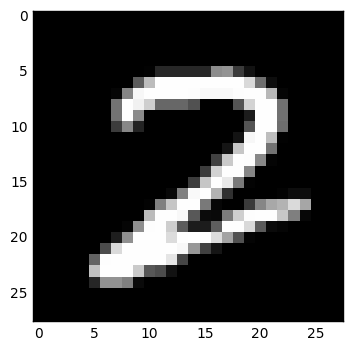

In [22]:
imageToUse = batch_data[0:64]
print (len(imageToUse))
plt.imshow(np.reshape(imageToUse[0],[28,28]), interpolation="nearest", cmap="gray")

# Convolutional Layer C1

(64, 28, 28, 6)


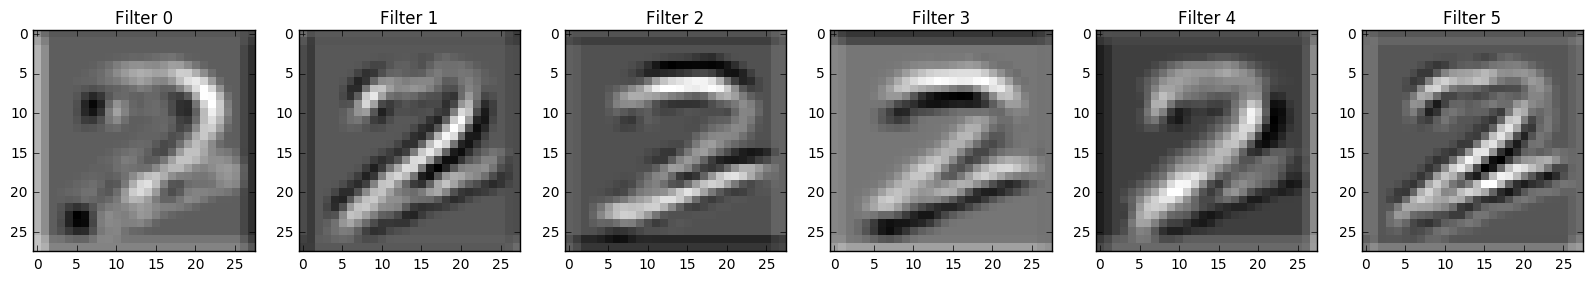

In [25]:
getActivations(model_train.conv1,imageToUse)

# ReLU Layer Relu1

(64, 28, 28, 6)


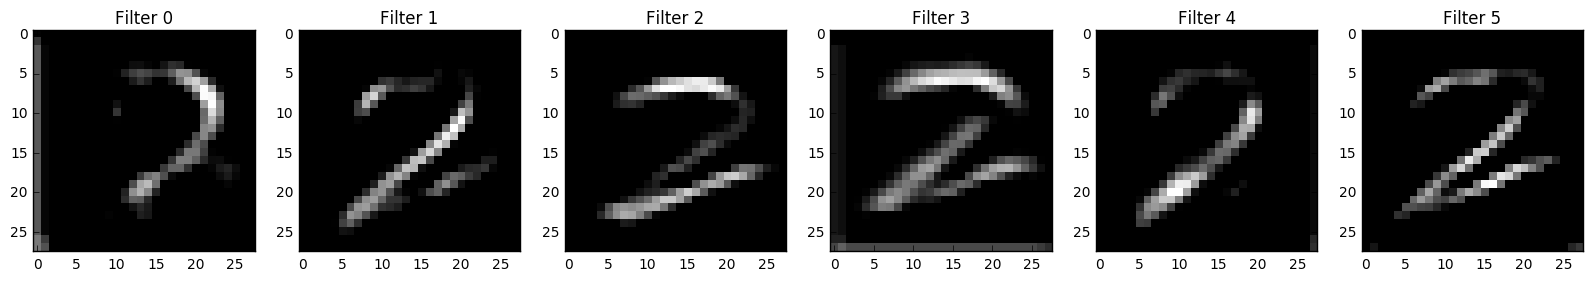

In [28]:
getActivations(model_train.relu1,imageToUse)

# Pool Layer S2

(64, 14, 14, 6)


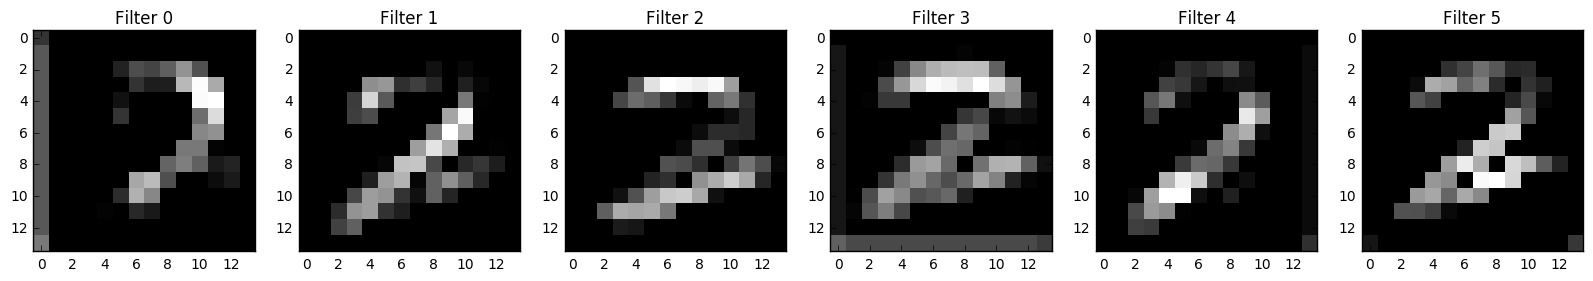

In [26]:
getActivations(model_train.pool2,imageToUse)

# Convolutional Layer C3

(64, 14, 14, 16)


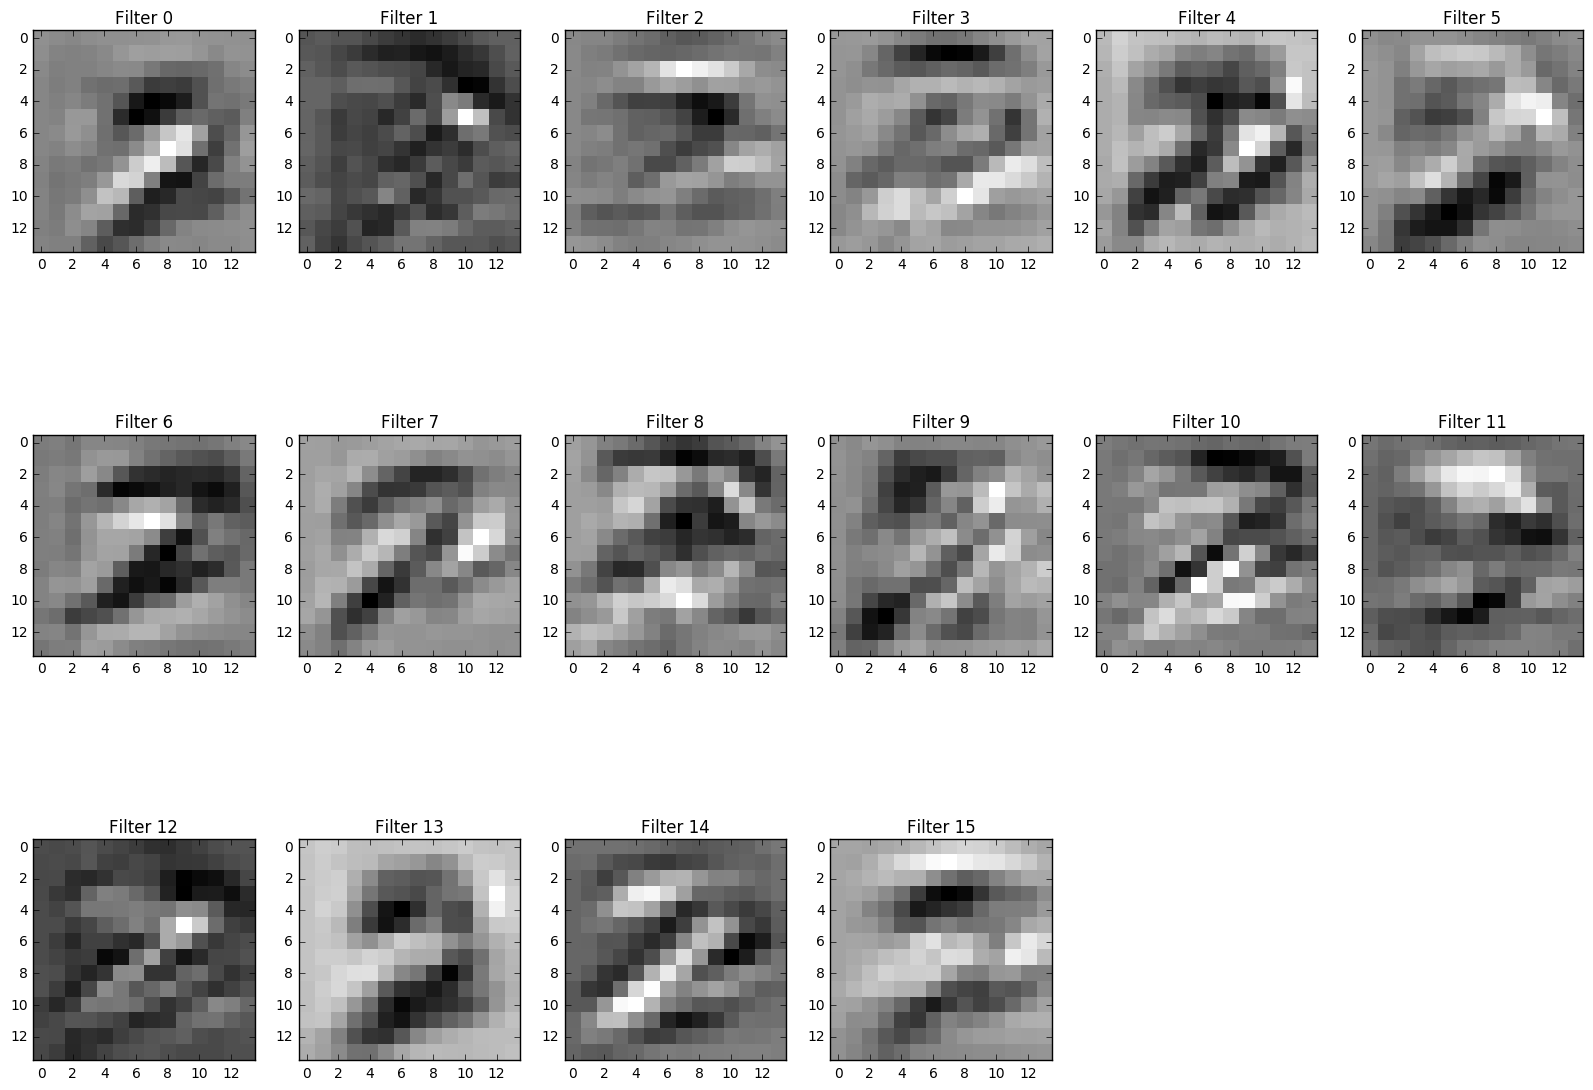

In [29]:
getActivations(model_train.conv3,imageToUse)

# ReLU Layer relu3

(64, 14, 14, 16)


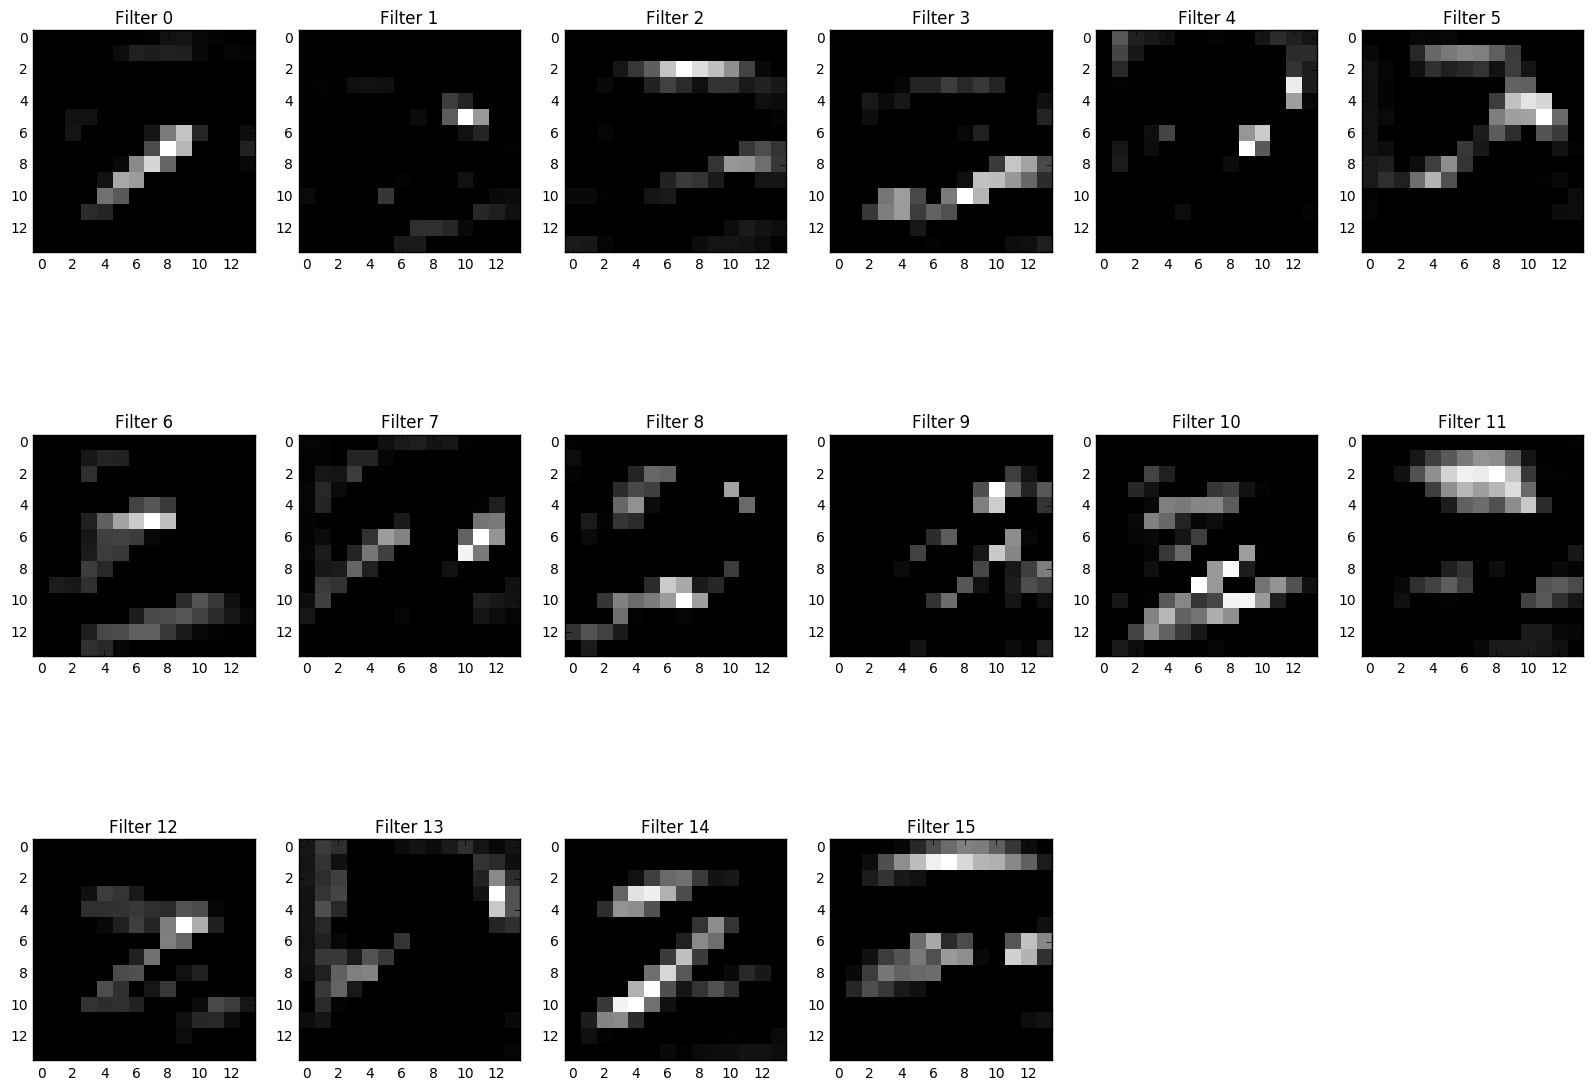

In [30]:
getActivations(model_train.relu3,imageToUse)

# Pool Layer S4

(64, 7, 7, 16)


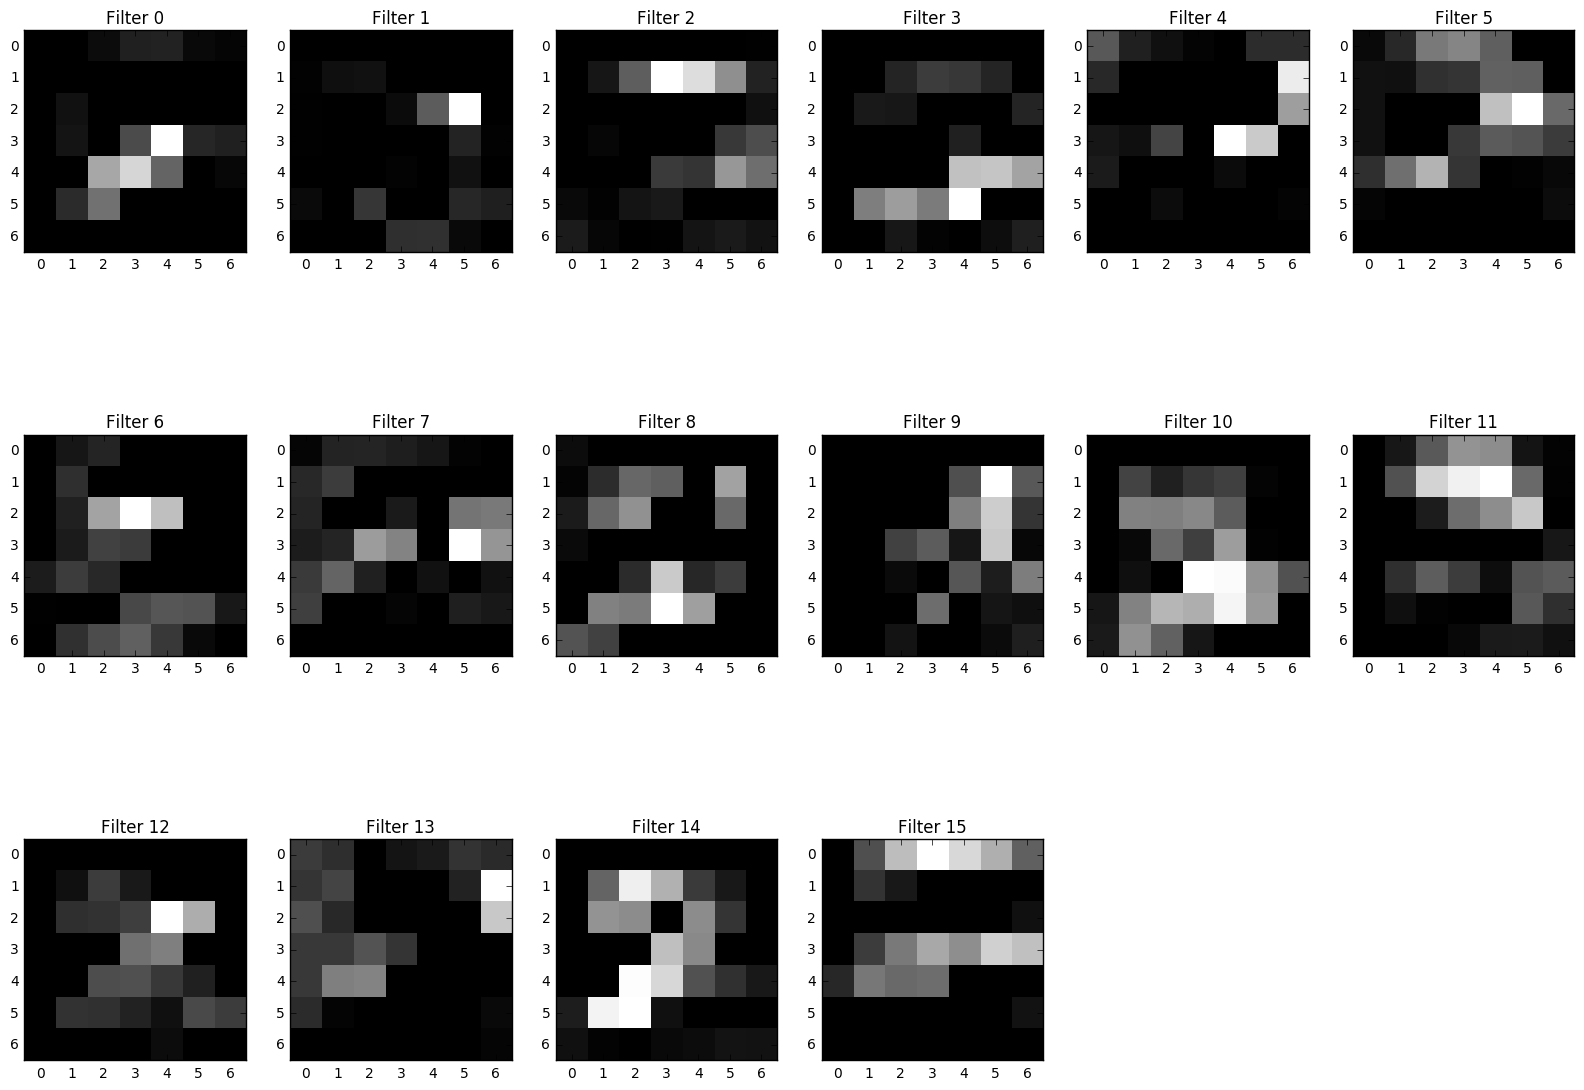

In [31]:
getActivations(model_train.pool4,imageToUse)